In [1]:
import matplotlib.pyplot as plt
def show(img):
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [55]:
# Import libraries
from plantcv import plantcv as pcv 

class options:
    def __init__(self):
        #self.image = '../../leafsnap/leafsnap-dataset/dataset/images/field/acer_rubrum/13001155906945.jpg'
        self.image = '../images/raws/acer_rubrum/13001155906945.jpg'
        self.debug = "plot"
        self.writeimg= 'False' 
        self.result = "features_metadata.json"
        self.outdir = ""
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug
pcv.params.debug = args.debug

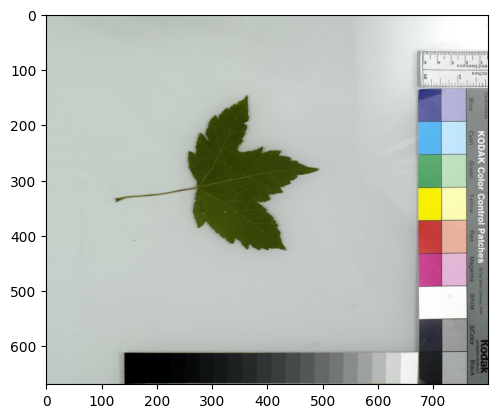

In [7]:
img, path, filename = pcv.readimage(filename="../../leafsnap/leafsnap-dataset/dataset/images/lab/acer_pseudoplatanus/wb1559-03-1.jpg")

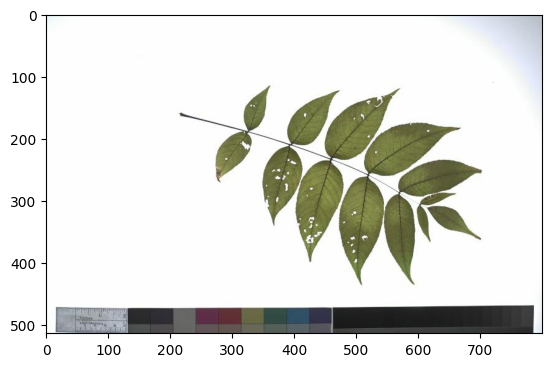

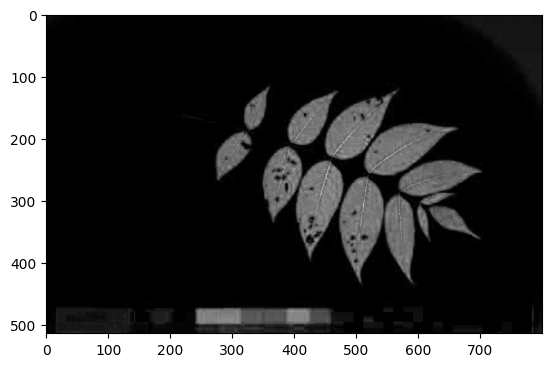

RGB to HSV


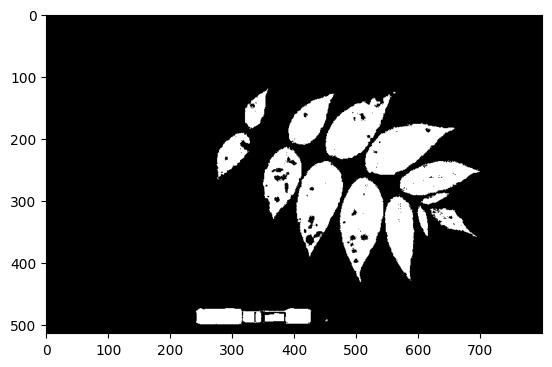

Threshold Saturation Image


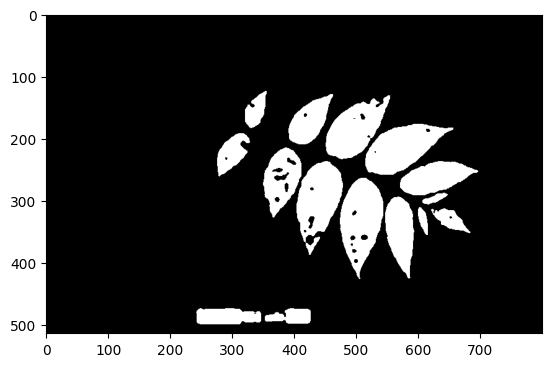

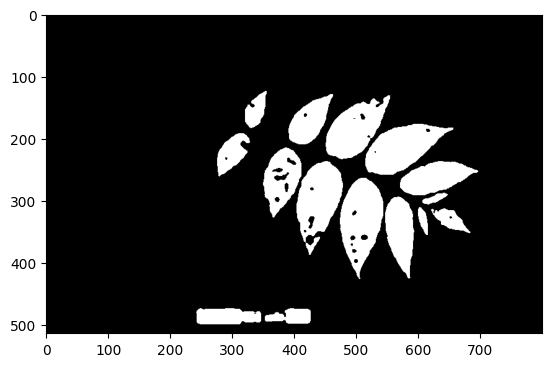

Median Blur


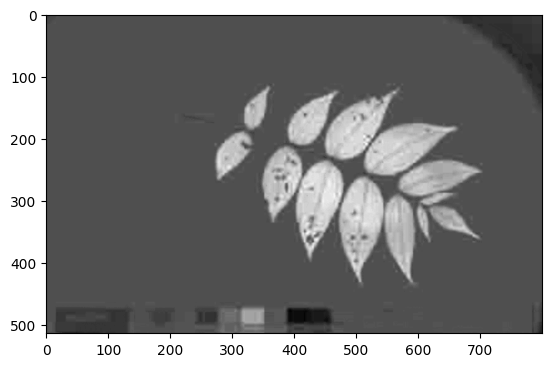

Extract Blue Channel


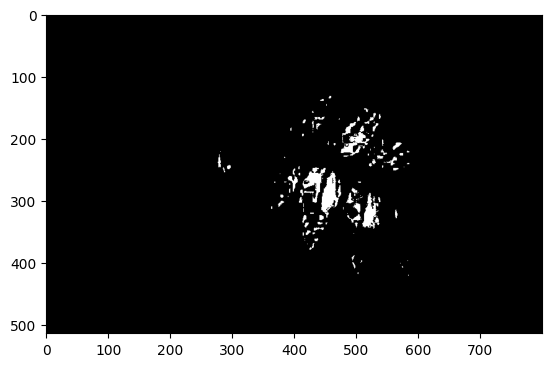

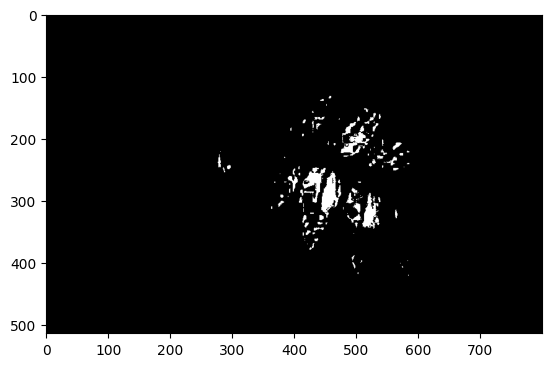

Threshold Blue Image


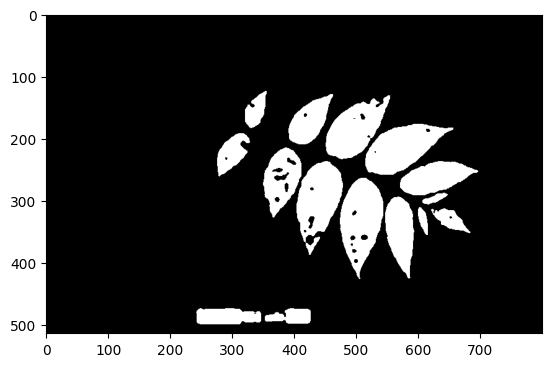

Join Thresholded saturation and blue-yellow imaes


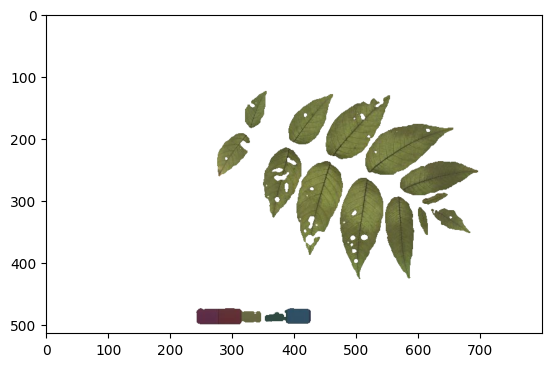

Apply Mask


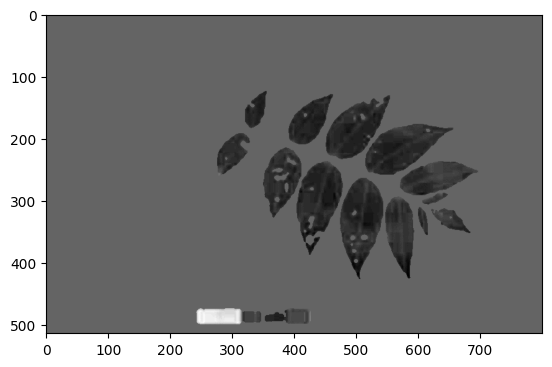

Extract green-magenta and blue-yellow channels


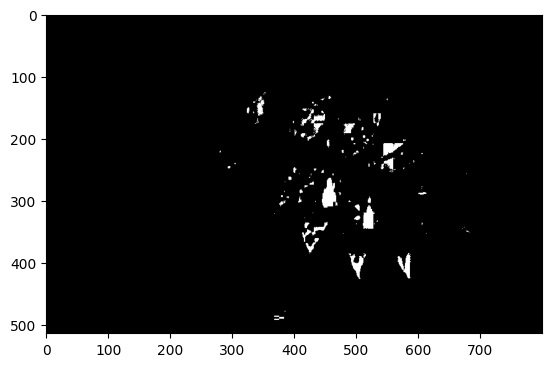

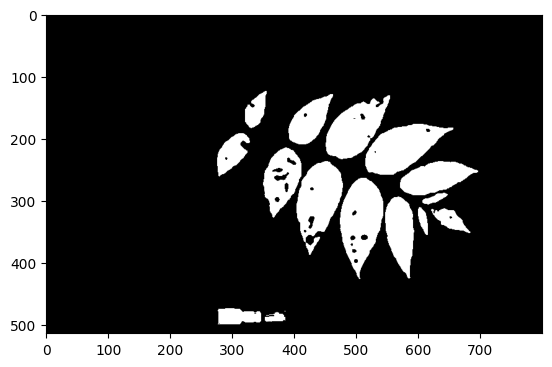

Thresold Green-magenda and blue images


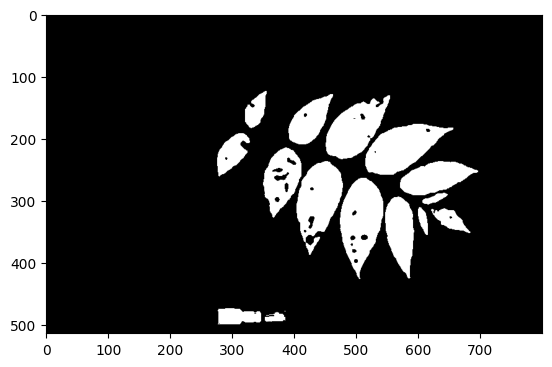

Join Threshold saturation and blue-yellow images


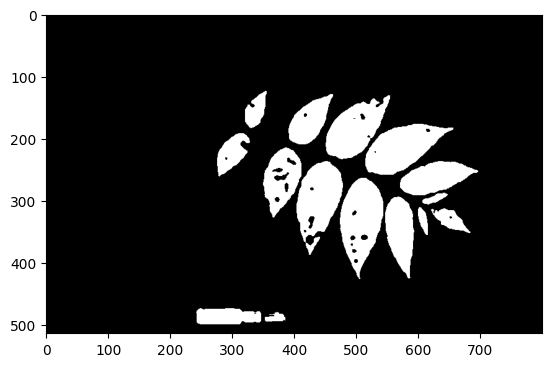

Fill small objects


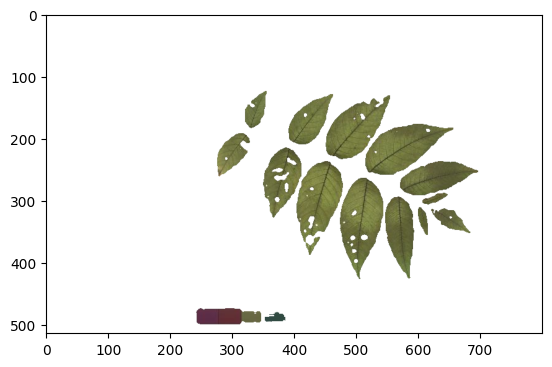

Apply 2nd Masked


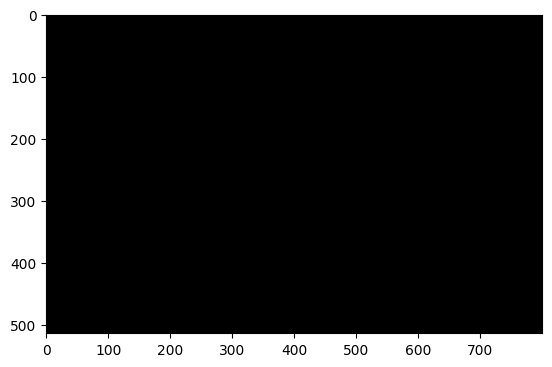

Skeletonize


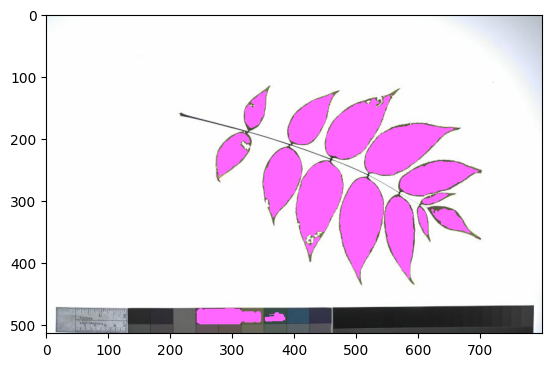

Identify Objects original


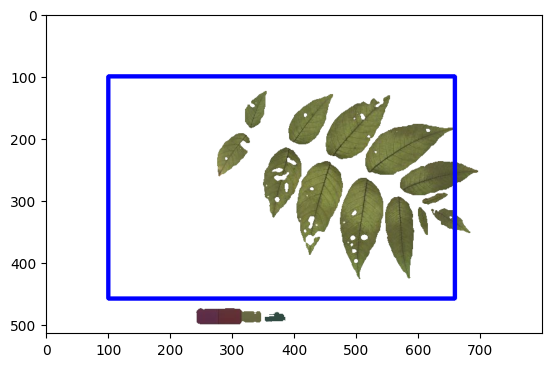

Define Region of Interest


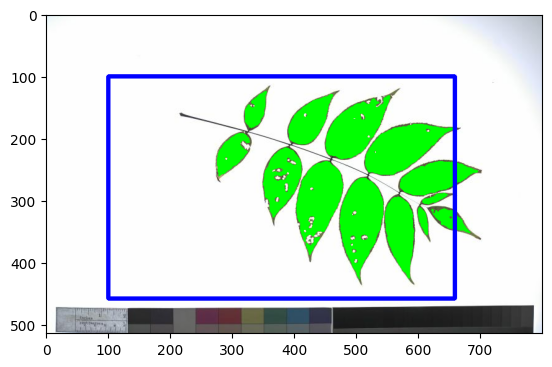

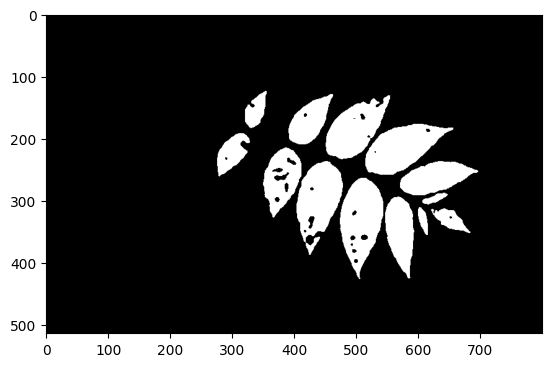

Decide which objects to keep
(array([[[641, 313]],

       [[640, 314]],

       [[639, 314]],

       [[638, 314]],

       [[637, 315]],

       [[636, 315]],

       [[635, 316]],

       [[634, 316]],

       [[634, 317]],

       [[633, 318]],

       [[632, 318]],

       [[631, 318]],

       [[630, 317]],

       [[630, 316]],

       [[629, 316]],

       [[628, 316]],

       [[628, 317]],

       [[627, 318]],

       [[627, 319]],

       [[627, 320]],

       [[626, 321]],

       [[625, 321]],

       [[624, 320]],

       [[624, 319]],

       [[624, 318]],

       [[624, 317]],

       [[625, 316]],

       [[625, 315]],

       [[624, 315]],

       [[623, 314]],

       [[622, 314]],

       [[621, 315]],

       [[621, 316]],

       [[622, 317]],

       [[623, 318]],

       [[623, 319]],

       [[623, 320]],

       [[624, 321]],

       [[624, 322]],

       [[625, 323]],

       [[626, 324]],

       [[627, 325]],

       [[627, 326]],

       [[628, 327]],

  

Combine kept objects


In [78]:
import cv2
import numpy as np
from plantcv import plantcv as pcv
import scipy.integrate

import skimage.io as io
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.color import label2rgb

# https://www.delftstack.com/howto/numpy/curvature-formula-numpy/
def compute_curvature(x, y): # get circle first // radius points inside 
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / ((dx_dt ** 2 + dy_dt ** 2) ** 1.5)
    return curvature


def compute_curvature_derivative(curvature):
    curvature_derivative = np.gradient(curvature)
    return curvature_derivative


def compute_curvature_integral(curvature):
    curvature_integral = np.trapz(curvature)
    return curvature_integral


# img, path, filename = pcv.readimage(filename=args.image)
# img, path, filename = pcv.readimage(filename="../../leafsnap/leafsnap-dataset/dataset/images/field/acer_saccharinum/13001158000696.jpg")
# img, path, filename = pcv.readimage(filename="../../leafsnap/leafsnap-dataset/dataset/images/lab/juglans_cinerea/wb1487-04-3.jpg")
# img, path, filename = pcv.readimage(filename="../../leafsnap/leafsnap-dataset/dataset/images/lab/celtis_occidentalis/pi0060-03-2.jpg")
# img, path, filename = pcv.readimage(filename="../../leafsnap/leafsnap-dataset/dataset/images/lab/juglans_nigra/pi2116-01-4.jpg")
# img, path, filename = pcv.readimage(filename="../../leafsnap/leafsnap-dataset/dataset/images/lab/abies_concolor/ny1157-02-4.jpg")

# Convert RGB to HSV and extract the saturation channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
print("RGB to HSV")

# Threshold the saturation image
s_thresh = pcv.threshold.binary(gray_img=s, threshold=85, max_value=255, object_type='light')
print("Threshold Saturation Image")

# Median Blur
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)
s_cnt = pcv.median_blur(gray_img=s_thresh, ksize=5)
print("Median Blur")

# Convert RGB to LAB and extract the Blue channel
#b = pcv.rgb2gray_lab(gray_img=img, channel='b')
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')
print("Extract Blue Channel")

# Threshold the blue image
b_thresh = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, object_type='light')
b_cnt = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, object_type='light')
print("Threshold Blue Image")

# Fill small objects
# b_fill = pcv.fill(b_thresh, 10)

# Join the thresholded saturation and blue-yellow images
bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_cnt)
print("Join Thresholded saturation and blue-yellow imaes")

# Apply Mask (for VIS images, mask_color=white)
#masked = pcv.apply_mask(rgb_img=img, mask=bs, mask_color='white')
masked = pcv.apply_mask(img=img, mask=bs, mask_color='white')
print("Apply Mask")
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')
print("Extract green-magenta and blue-yellow channels")

# Threshold the green-magenta and blue images
maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, max_value=255, object_type='dark')
maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, max_value=255, object_type='light')
maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, max_value=255, object_type='light')
print("Thresold Green-magenda and blue images")

# Join the thresholded saturation and blue-yellow images (OR)
ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)
print("Join Threshold saturation and blue-yellow images")

# Fill small objects
ab_fill = pcv.fill(bin_img=ab, size=200)
print("Fill small objects")

# Apply mask (for VIS images, mask_color=white)
#masked2 = pcv.apply_mask(rgb_img=masked, mask=ab_fill, mask_color='white')
masked2 = pcv.apply_mask(img=masked, mask=ab_fill, mask_color='white')
print("Apply 2nd Masked")

skeleton = pcv.morphology.skeletonize(mask=masked2)
print("Skeletonize")

# Identify objects
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=ab_fill)
print("Identify Objects original")




# # Identify objects 2
# id_objects2, obj_hierarchy2 = pcv.find_objects(img=s_thresh, mask=s)
# print("Identify Objects binary")

# # Select the first contour (assuming there is only one)
# contour = id_objects2[0]

# # Fit parabolas to small segments of the contour and compute the curvature at each point
# segment_size = 10
# curvatures = []
# for i in range(segment_size, len(contour) - segment_size, segment_size):
#     x = contour[i-segment_size:i+segment_size+1, 0]
#     y = contour[i-segment_size:i+segment_size+1, 1]
#     a, b, c = pcv.fit_parabola(x, y)
#     curvature = abs(2*a) / ((1 + b**2)**(3/2))
#     curvatures.append(curvature)

# # Compute the curvature derivative for the contour
# curvature_derivative = np.gradient(curvatures)
# # Compute the curvature integral and total curvature for the contour
# curvature_integral = np.trapz(curvatures)
# total_curvature = abs(curvature_integral)

# print("Curvature:", curvatures)
# print("Curvature derivative:", curvature_derivative)
# print("Curvature integral:", curvature_integral)
# print("Total curvature:", total_curvature)

# get dimensions of image
dimensions = img.shape
 
# height, width, number of channels in image
height = img.shape[0] - (img.shape[0] * (30 / 100))
width = img.shape[1] - (img.shape[1] * (30 / 100))

# Define ROI
roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=100, y=100, h=height, w=width)
print("Define Region of Interest")


# # Auto-define the ROI using the "auto_roi" function
# roi1, roi_heirarchy = pcv.auto_roi(masked2)



# Decide which objects to keep
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                               roi_hierarchy=roi_hierarchy, 
                                                               object_contour=id_objects, 
                                                               obj_hierarchy=obj_hierarchy,
                                                               roi_type='partial')
print("Decide which objects to keep")
print(roi_objects)

# Object combine kept objects
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)
print("Combine kept objects")

In [90]:
s_thresh

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# Compute threshold based on standard deviation of pixel intensities inside each contour
thresholds = []
for contour in contours:
    # Extract pixel intensities inside the contour
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [contour], 0, 255, -1)
    intensities = img[np.where(mask == 255)]
    # Compute standard deviation and use a multiple of it as the threshold value
    std = np.std(intensities)
    threshold = int(np.mean(intensities) - 2 * std)
    thresholds.append(threshold)

# Apply adaptive thresholding using the computed thresholds
result = np.zeros_like(img)
for contour, threshold in zip(contours, thresholds):
    # Extract pixel intensities inside the contour
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [contour], 0, 255, -1)
    intensities = img[np.where(mask == 255)]
    # Apply adaptive thresholding using the computed threshold
    binary_contour = cv2.adaptiveThreshold(intensities, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, threshold)
    # Insert the binary contour into the result image
    result[np.where(mask == 255)] = binary_contour

# Show the result
cv2.imshow('Result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [141]:
# img, path, filename = pcv.readimage(filename=args.image)
img, path, filename = pcv.readimage(filename="../../leafsnap/leafsnap-dataset/dataset/images/field/acer_saccharinum/13001158000696.jpg")

# Convert RGB to HSV and extract the saturation channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
print("RGB to HSV")

# Threshold the saturation image
s_thresh = pcv.threshold.binary(gray_img=s, threshold=85, max_value=255, object_type='light')
print("Threshold Saturation Image")

RGB to HSV


Threshold Saturation Image


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Load the features extracted from the database of lab and field images
database_features = np.load("path/to/database_features.npy")

# Create a nearest neighbors object with n_neighbors set to 25
nbrs = NearestNeighbors(n_neighbors=25, algorithm='auto', metric='hik').fit(database_features)

# Use the HoCS feature vector extracted from the input image as the query
query = HoCS.reshape(1, -1)

# Perform the nearest neighbors search
distances, indices = nbrs.kneighbors(query)
import matplotlib.pyplot as plt
from PIL import Image

# Load the list of species labels
species_labels = np.load("path/to/species_labels.npy")

# Show the top 25 matches to the user
for i in range(len(indices[0])):
    index = indices[0][i]
    distance = distances[0][i]
    species = species_labels[index]
    image_path = "path/to/images/" + str(index) + ".jpg" # Assuming the images are named as their corresponding index in the database

    # Load and show the matched image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.show()

    # Print the match information
    print("Match", i+1, ":", species, "(Distance:", distance, ")")
# Assuming that you have already loaded the database of features and the list of species labels
# as numpy arrays called database_features and species_labels, respectively

from sklearn.model_selection import LeaveOneOut

# Perform leave-one-image-out species identification using only the field images as queries
loo = LeaveOneOut()

correct_ranks = []
for train_index, test_index in loo.split(database_features):
    # Only use field images as queries
    if "field" not in image_paths[test_index[0]]:
        continue

    # Extract the HoCS feature vector from the query image
    query = database_features[test_index[0]]

    # Perform the nearest neighbors search
    distances, indices = nbrs.kneighbors(query.reshape(1, -1))

    # Get the species labels of the matches
    match_species = species_labels[indices[0]]

    # Get the true species label of the query image
    true_species = species_labels[test_index[0]]

    # Calculate the species match rank
    rank = np.where(match_species == true_species)[0][0] + 1

    correct_ranks.append(rank)

# Calculate the recognition rate as a function of the maximum species match rank
recognition_rates = []
for i in range(1, 26):
    recognition_rate = sum([1 for rank in correct_ranks if rank <= i]) / len(correct_ranks)
    recognition_rates.append(recognition_rate)



RGB to HSV


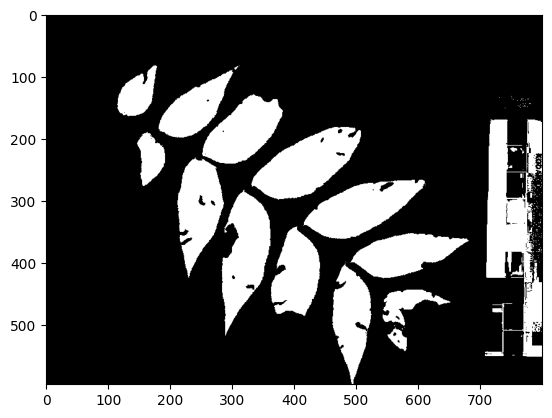

Threshold Saturation Image


Median Blur


Extract Blue Channel


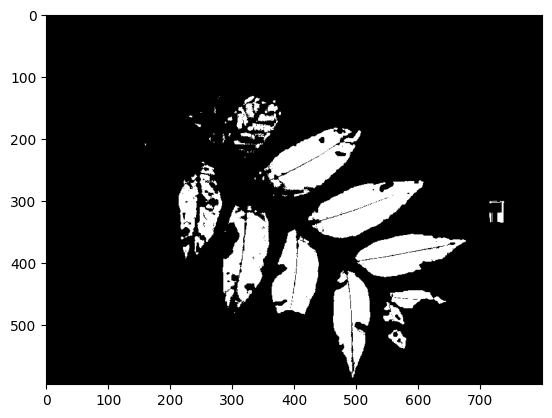

Threshold Blue Image


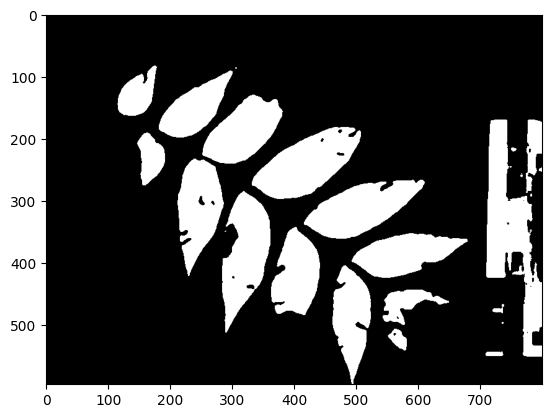

Join Thresholded saturation and blue-yellow imaes


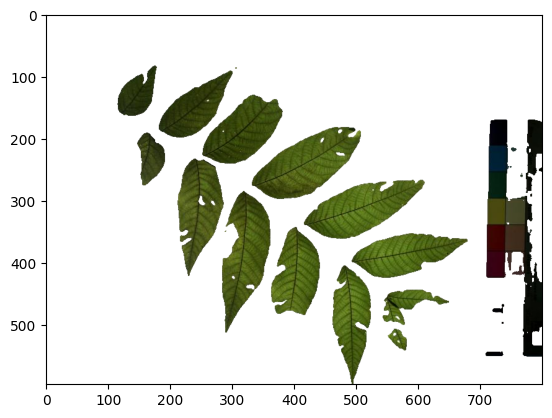

Apply Mask


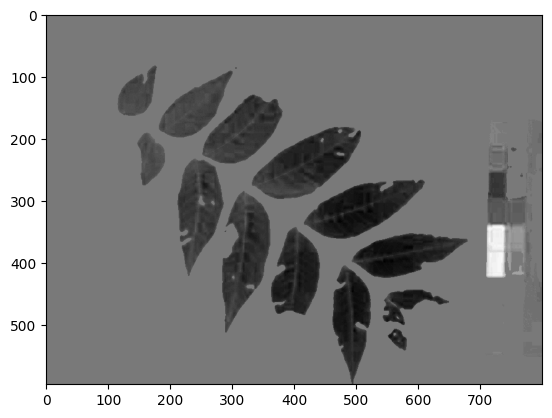

Extract green-magenta and blue-yellow channels


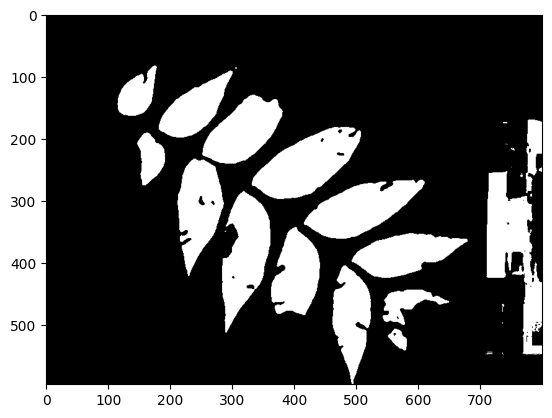

Thresold Green-magenda and blue images


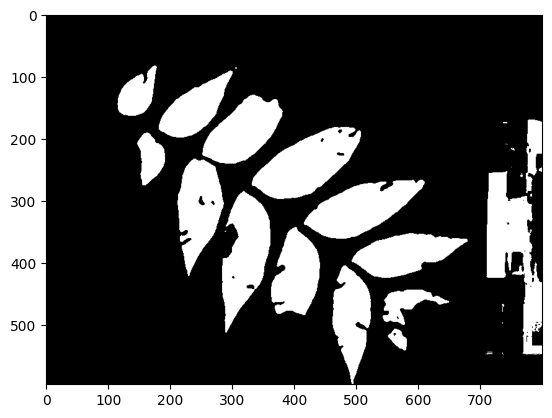

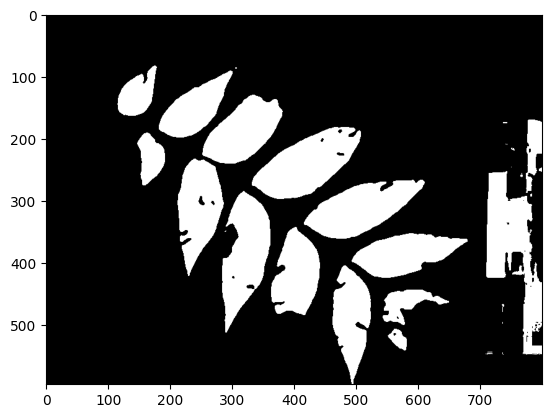

Join Threshold saturation and blue-yellow images


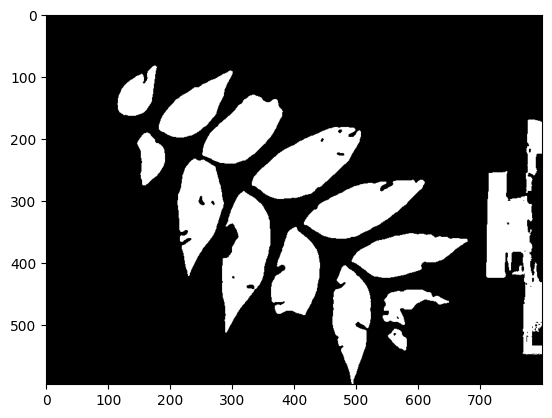

Fill small objects


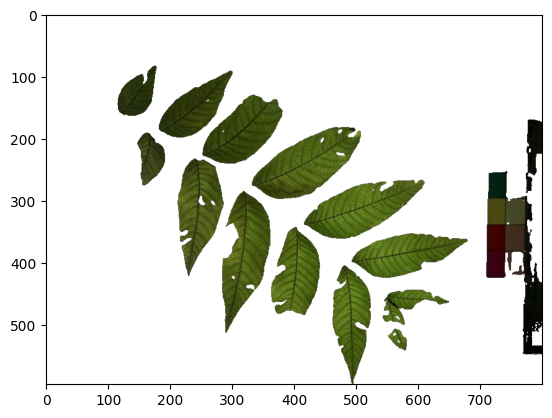

Apply 2nd Masked


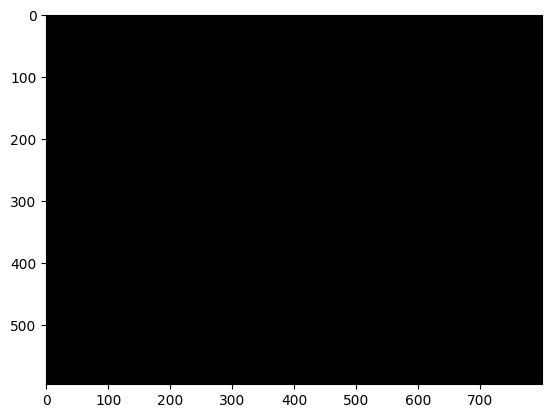

Skeletonize


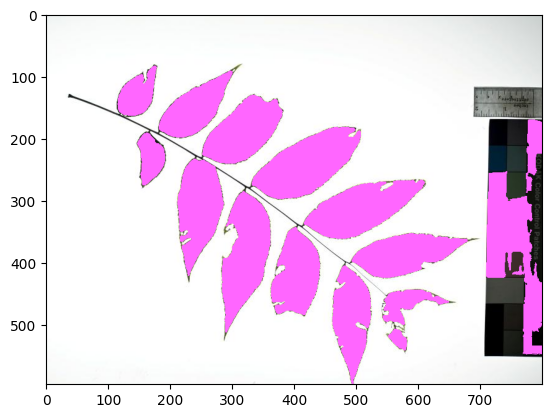

Identify Objects original


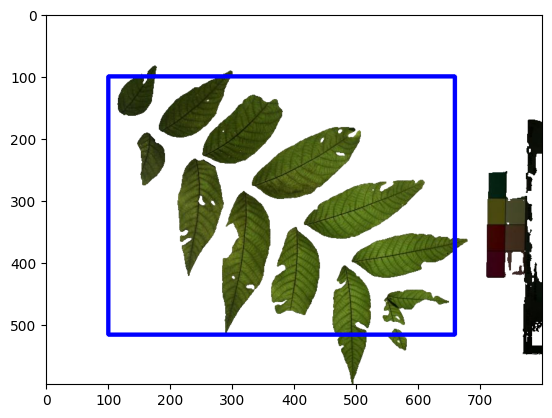

Define Region of Interest


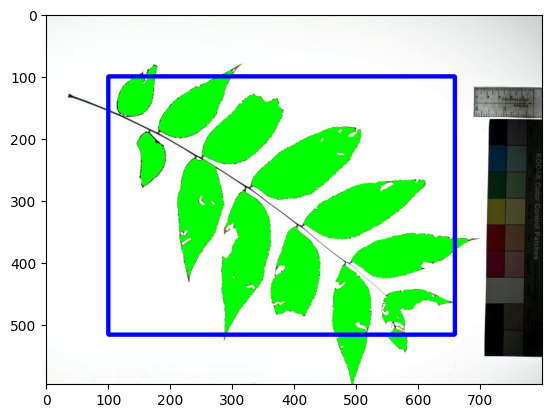

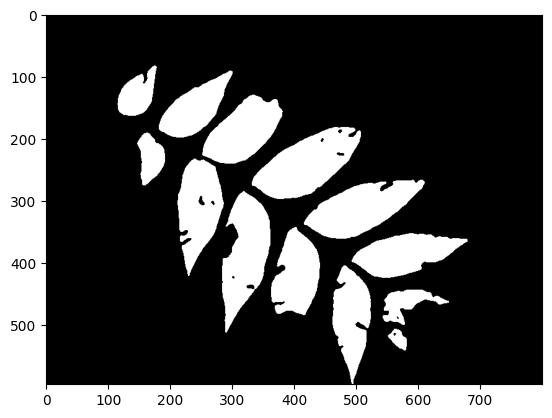

Decide which objects to keep
(array([[[561, 507]],

       [[561, 508]],

       [[560, 509]],

       [[559, 510]],

       [[558, 511]],

       [[558, 512]],

       [[557, 513]],

       [[556, 514]],

       [[555, 515]],

       [[554, 515]],

       [[553, 516]],

       [[552, 517]],

       [[551, 518]],

       [[552, 519]],

       [[552, 520]],

       [[553, 521]],

       [[554, 522]],

       [[555, 523]],

       [[556, 524]],

       [[557, 525]],

       [[558, 526]],

       [[558, 527]],

       [[559, 528]],

       [[560, 529]],

       [[561, 530]],

       [[562, 531]],

       [[563, 532]],

       [[564, 533]],

       [[565, 534]],

       [[566, 534]],

       [[567, 535]],

       [[568, 536]],

       [[569, 537]],

       [[570, 538]],

       [[571, 538]],

       [[572, 538]],

       [[573, 538]],

       [[574, 539]],

       [[575, 539]],

       [[576, 540]],

       [[577, 541]],

       [[578, 541]],

       [[579, 541]],

       [[580, 540]],

  

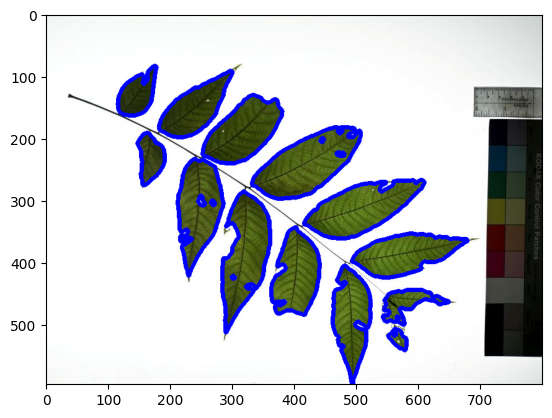

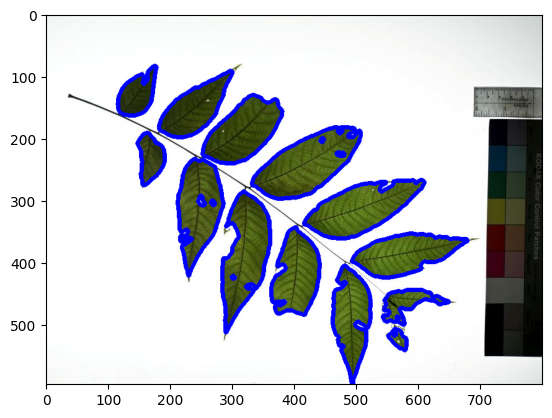

Combine kept objects


In [93]:
import cv2
import numpy as np
from plantcv import plantcv as pcv
import scipy.integrate

import skimage.io as io
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.color import label2rgb

# https://www.delftstack.com/howto/numpy/curvature-formula-numpy/
def compute_curvature(x, y): # get circle first // radius points inside 
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / ((dx_dt ** 2 + dy_dt ** 2) ** 1.5)
    return curvature


def compute_curvature_derivative(curvature):
    curvature_derivative = np.gradient(curvature)
    return curvature_derivative


def compute_curvature_integral(curvature):
    curvature_integral = np.trapz(curvature)
    return curvature_integral


# img, path, filename = pcv.readimage(filename=args.image)
# img, path, filename = pcv.readimage(filename="../../leafsnap/leafsnap-dataset/dataset/images/field/acer_saccharinum/13001158000696.jpg")
# img, path, filename = pcv.readimage(filename="../../leafsnap/leafsnap-dataset/dataset/images/lab/juglans_cinerea/wb1487-04-3.jpg")
# img, path, filename = pcv.readimage(filename="../../leafsnap/leafsnap-dataset/dataset/images/lab/celtis_occidentalis/pi0060-03-2.jpg")
img, path, filename = pcv.readimage(filename="../../leafsnap/leafsnap-dataset/dataset/images/lab/juglans_nigra/pi2116-01-4.jpg")
# img, path, filename = pcv.readimage(filename="../../leafsnap/leafsnap-dataset/dataset/images/lab/abies_concolor/ny1157-02-4.jpg")

# img, path, filename = pcv.readimage(filename=img)

pcv.params.debug = "plot"
# Resize image using resize function, with interpolation, and default interpolation method
# img = pcv.transform.resize(img=img, size=(400, 300), interpolation="auto")

# Convert RGB to HSV and extract the saturation channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
print("RGB to HSV")
# Threshold the saturation image
s_thresh = pcv.threshold.binary(gray_img=s, threshold=85, max_value=255, object_type='light')
print("Threshold Saturation Image")
# Median Blur
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)
s_cnt = pcv.median_blur(gray_img=s_thresh, ksize=5)
print("Median Blur")
# Convert RGB to LAB and extract the Blue channel
#b = pcv.rgb2gray_lab(gray_img=img, channel='b')
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')
print("Extract Blue Channel")
# Threshold the blue image
b_thresh = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, object_type='light')
b_cnt = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, object_type='light')
print("Threshold Blue Image")
# Fill small objects
# b_fill = pcv.fill(b_thresh, 10)
# Join the thresholded saturation and blue-yellow images
bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_cnt)
print("Join Thresholded saturation and blue-yellow imaes")
# Apply Mask (for VIS images, mask_color=white)
#masked = pcv.apply_mask(rgb_img=img, mask=bs, mask_color='white')
masked = pcv.apply_mask(img=img, mask=bs, mask_color='white')
print("Apply Mask")
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')
print("Extract green-magenta and blue-yellow channels")
# Threshold the green-magenta and blue images
maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, max_value=255, object_type='dark')
maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, max_value=255, object_type='light')
maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, max_value=255, object_type='light')
print("Thresold Green-magenda and blue images")
# Join the thresholded saturation and blue-yellow images (OR)
ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)
print("Join Threshold saturation and blue-yellow images")
# Fill small objects
ab_fill = pcv.fill(bin_img=ab, size=200)
print("Fill small objects")
# Apply mask (for VIS images, mask_color=white)
#masked2 = pcv.apply_mask(rgb_img=masked, mask=ab_fill, mask_color='white')
masked2 = pcv.apply_mask(img=masked, mask=ab_fill, mask_color='white')
print("Apply 2nd Masked")
skeleton = pcv.morphology.skeletonize(mask=masked2)
print("Skeletonize")
# Identify objects
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=ab_fill)
print("Identify Objects original")
dimensions = img.shape

# height, width, number of channels in image
height = img.shape[0] - (img.shape[0] * (30 / 100))
width = img.shape[1] - (img.shape[1] * (30 / 100))
# Define ROI
roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=100, y=100, h=height, w=width)
print("Define Region of Interest")
# # Auto-define the ROI using the "auto_roi" function
# roi1, roi_heirarchy = pcv.auto_roi(masked2)
# Decide which objects to keep
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                               roi_hierarchy=roi_hierarchy, 
                                                               object_contour=id_objects, 
                                                               obj_hierarchy=obj_hierarchy,
                                                               roi_type='partial')
print("Decide which objects to keep")
print(roi_objects)
# Object combine kept objects
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)
print("Combine kept objects")

In [91]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [92]:
s_thresh

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)